# Score for the Fed's dual mandate

The U.S. Congress established three key objectives for monetary policy 
in the Federal Reserve Act: *Maximum employment, stable prices*, and 
moderate long-term interest rates. The first two objectives are 
sometimes referred to as the Federal Reserve's **dual mandate**. 

Here we examine unemployment and inflation data to construct 
a time-series which gives a numerical score to the 
Fed's performance on the dual mandate. 
(This notebook could be extended to studies of 
the *Phillips curve*, see Appendix 1).

The key is to find comparable units to measure performance 
and a suitable scalar measure to show deviation 
from the dual mandate. 
The visualization includes *sequential* scatter plots using color heat map.

*Dependencies:*

- fecon235 repository https://github.com/rsvp/fecon235
- Python: matplotlib, pandas, yi_0sys, fecon
     
*CHANGE LOG*

    2015-12-15  Switch to yi_0sys dependencies. Phillips curve.
    2015-11-18  First version.

In [1]:
#  NOTEBOOK v4 SETTINGS and system details:      [00-tpl v5.15.1203]
from __future__ import print_function
#    Strive for compatibility between Python 2, 3, Jupyter, 
#    and being cross-platform (our backend is LINUX running bash shell). 
import yi_0sys      ; yi_0sys.specs()
import pandas as pd
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.
pwd = yi_0sys.getpwd()    # present working directory as variable.
print(" ::  $pwd:", pwd)

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
pd.set_option( 'display.notebook_repr_html', False )
#  Beware, for MATH display, use %%latex, NOT the following:
#                   from IPython.display import Math
#                   from IPython.display import Latex
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Timestamp: 2015-12-16, 16:49:44 UTC
 ::  Python 2.7.10
 ::  IPython 4.0.0
 ::  notebook 4.0.6
 ::  matplotlib 1.4.3
 ::  numpy 1.10.1
 ::  pandas 0.17.1
 ::  pandas_datareader 0.2.0
 ::  $pwd: /media/yaya/virt15h/virt/dbx/Dropbox/ipy/fecon235/nb


In [2]:
#  MAIN module: 
from fecon import *

## Comparable unit for comparison

One percent change in inflation may have different economic significance 
than an one percent change in unemployment. 
We collect historical data and then let one standard deviation 
represent one unit for scoring purposes. 
Note that the past scores will thus be represented *ex-post*, 
which is to say, influenced by recent data.

Historically the dual mandate is not required to be explicitly 
stated numerically by the Federal Reserve, 
so we assign current values (mentioned in Congressional testimonies 
and used by the market).

Sidenote: "The natural rate of unemployment 
[**NAIRU**, *non-accelerating inflation rate of unemployment*] 
is the rate of unemployment 
arising from all sources except fluctuations in aggregate demand. 
Estimates of potential GDP are based on the long-term natural rate. 
The short-term natural rate is used to gauge the amount of current 
and projected slack in labor markets." 
See https://research.stlouisfed.org/fred2/series/NROU 
and Appendix 1 for details.

In [3]:
#  Set DUAL MANDATE, assumed throughout this notebook:
unem_target = 5.0
infl_target = 2.0

#  The Fed varies the targets over time, 
#  sometimes only implicitly. So for example,
#  there may be disagreement among Board members
#  regarding NAIRU -- but we set it to what
#  seems to be the prevelant market assumption.

### Unemployment rate

In [4]:
unem = get( m4unemp )
#           m4 implies monthly frequency.

In [5]:
# #  Starts 1948-01-01, uncomment to view:
# stats( unem )

In [6]:
#  Standard deviation for unemployment rate:
unem_std = unem.std()
unem_std

Y    1.645711
dtype: float64

In [7]:
#  Uncomment to plot raw unemployment rate:
#  plot( unem )

In [8]:
#  Score unemployment as standard deviations from target: 
unem_score = todf( (unem - unem_target) / unem_std )

## Inflation

In [9]:
#  Use synthetic inflation
#  which averages CPI and PCE for both headline and core versions:
infl_level = get( m4infl )

In [10]:
#  Get the YoY inflation rate:
infl = todf(pcent( infl_level, 12 ))

In [11]:
#  #  Starts 1960-01-01, uncomment to view:
#  stats(infl)

In [12]:
infl_std = infl.std()
infl_std

Y    2.463776
dtype: float64

In [13]:
#  #  Uncomment to plot inflation rate:
#  plot( infl )

In [14]:
#  Score inflation as standard deviations from target:
infl_score = todf( (infl - infl_target) / infl_std )

## Expressing duality as complex number

We encode each joint score for unemployment and inflation into a single complex number. 
Let *u* be the unemployment score and *i* the inflation score. 
(Note: we follow the Python/engineering convention by letting **j** 
be the imaginary number $\sqrt -1$.) 
So let *z* be our dual encoding as follows:

$ z = u + i \mathbf{j} $


In [15]:
#  Let's start constructing our 4-column dataframe:
scores = paste( [unem_score, infl_score, infl_score, infl_score ] )
#  The last two columns are placeholders to be filled in later.

In [16]:
#  Give names to the scores columns:
scores.columns = ['z_unem', 'z_infl', 'z', 'z_norm']

In [17]:
#  Fill in third column z as complex number per our discussion:
scores.z = scores.z_unem + (scores.z_infl * 1j)
#  The imaginary number in itself in Python is represented as 1j, 
#  since j may be a variable elsewhere.

## Computing the Fed score

Each dual score can be interpreted as a vector in the 
complex plane. Its component parts, real for unemployment 
and imaginary for inflation, measure deviation from 
respective targets in units expressed as standard deviations.

*Our **key idea** is to use the length of this vector (from 
the origin, 0+0**j**, representing the dual mandate) as 
the Fed score* = |z|.

Python, which natively handles complex numbers, can 
compute the *norm* of such a vector using abs(z).

Later we shall visualize the trajectory of the component 
parts using a color heat map.

In [18]:
#  Finally fill-in the last placeholder column:
scores.z_norm = abs( scores.z ) 

In [19]:
#  Tail end of recent scores:
tail( scores )
#  ... nicely reveals the data structure.

              z_unem    z_infl                                  z    z_norm
T                                                                          
2015-04-01  0.243056 -0.490854    (0.24305602477-0.490854024015j)  0.547735
2015-05-01  0.303820 -0.480551    (0.303820030963-0.48055058282j)  0.568538
2015-06-01  0.182292 -0.449231   (0.182292018578-0.449230713674j)  0.484808
2015-07-01  0.182292 -0.450940   (0.182292018578-0.450940448571j)  0.486393
2015-08-01  0.060764 -0.444363  (0.0607640061926-0.444363070321j)  0.448498
2015-09-01  0.060764 -0.472241  (0.0607640061926-0.472241024051j)  0.476134
2015-10-01  0.000000 -0.455367                   -0.455367317086j  0.455367

## Visualizing Fed scores

z_norm is expressed in standard deviation units, thus 
it truly represents deviation from the dual mandate 
on a Gaussian scale.

In [20]:
#  Define descriptive dataframe from our mathematical construct:
fed_score = todf( scores.z_norm )

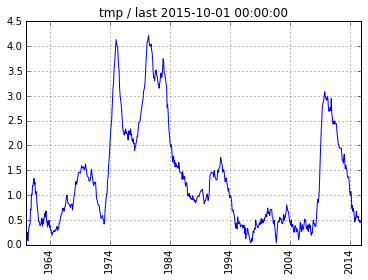

In [21]:
#     FED SCORE
plot( fed_score )

We can say that a score greater than 2 is definitively cause for concern. 
For example, between 1974 and 1984, there are two peaks 
extending into 4 standard deviations mainly due to high inflation. 
Fed score during the Great Recession hit 3 mainly due to 
severe unemployment.

In [22]:
stats( fed_score )

                Y
count  670.000000
mean     1.319386
std      1.022282
min      0.038742
25%      0.478725
50%      0.992521
75%      1.827236
max      4.213808

 ::  Index on min:
Y   2001-09-01
dtype: datetime64[ns]

 ::  Index on max:
Y   1980-06-01
dtype: datetime64[ns]

 ::  Head:
                   Y
T                   
1960-01-01  0.157569
1960-02-01  0.128110
1960-03-01  0.253779
1960-04-01  0.123955
1960-05-01  0.079440
1960-06-01  0.268799
1960-07-01  0.354802

 ::  Tail:
                   Y
T                   
2015-04-01  0.547735
2015-05-01  0.568538
2015-06-01  0.484808
2015-07-01  0.486393
2015-08-01  0.448498
2015-09-01  0.476134
2015-10-01  0.455367

 ::  Correlation matrix:
   Y
Y  1


### Remarks on fed_score

Our fed_score *handles both positive and negative deviations from the Fed's dual mandate*, 
moreover, it handles them jointly using a historical fair measuring unit: 
the standard deviation. This avoids using ad-hoc weights to balance 
the importance between unemployment and inflation.

The **fed_score is always a positve real number (since it is a norm) 
which is zero if and only if the Fed has achieved targets** 
(which we have explicitly specified). 
*That score can be interpreted as the number of standard deviations 
away from the dual mandate.*

Our **fed_score** can also be simply interpreted 
as an economic **crisis level** indicator 
(much like a *n-alarm* fire) when Fed monetary 
policy becomes crucial for the US economy.

Since 1960, ex-post fed_score averages 1.32 where 
the mid-50% percentile range is [0.48, 1.83].
But keep in mind that this computation relies on our 
current fixed targets, so fed_score is most 
useful in accessing recent performance 
from the perspective of historical variance.

2015-12-15: The current fed_score is 0.46 
gravitating towards zero as the Fed is preparing 
its first rate hike in a decade.


## Visualizing fed_score components over time

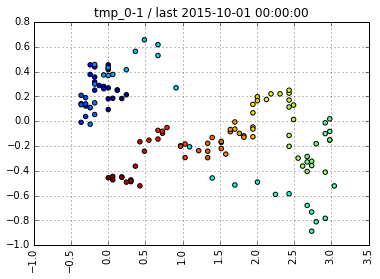

In [26]:
#  Scatter plot of recent data using color heat map:
scatter( scores['2005':], col=[0, 1] )
#  (Ignore FutureWarning from matplotlib/collections.py:590
#   regarding elementwise comparison due to upstream numpy.)

In this scatter plot: z_unem is shown along the x-axis, 
z_infl along the y-axis, 
such that the color 
heat map depicts chronological movement 
from blue to green to red. 

The coordinate (0, 0) represents the Fed dual mandate, 
so it is easy to see deviations from target. 
Geometrically a point's distance from the origin is what 
we have computed as fed_score (= z_norm, in the complex plane).


# Appendix 1: Phillips curve

The Phillips curve purports to explain the relationship between 
inflation and unemployment, however, as it turns out the 
relationship is one of mere correlation during certain periods 
in a given country. It is too simplistic to assert that 
decreased unemployment (i.e. increased levels of employment) 
will cause with the inflation rate to increase.

"Most economists no longer use the Phillips curve in its original 
form because it was shown to be too simplistic. This can be seen 
in a cursory analysis of US inflation and unemployment data from 
1953-92. There is no single curve that will fit the data, but 
there are three rough aggregations—1955–71, 1974–84, and 1985–92 — 
each of which shows a general, downwards slope, but at three 
very different levels with the shifts occurring abruptly. 
The data for 1953-54 and 1972-73 do not group easily, 
and a more formal analysis posits up to five groups/curves 
over the period.

Modern versions distinguish between short-run and long-run 
effects on unemployment. The "short-run Phillips curve" is also called 
the "expectations-augmented Phillips curve," since it shifts up when 
inflationary expectations rise. In the long run, this implies 
that monetary policy cannot affect unemployment, 
which adjusts back to its "natural rate", also called the "NAIRU" or 
"long-run Phillips curve". However, this long-run "neutrality" of 
monetary policy does allow for short run fluctuations and the ability 
of the monetary authority to temporarily decrease unemployment 
by increasing permanent inflation, and vice versa.

In many recent stochastic general equilibrium models, with sticky prices, 
there is a positive relation between the rate of inflation and 
the level of demand, and therefore a negative relation between 
the rate of inflation and the rate of unemployment. This relationship is 
often called the "New Keynesian Phillips curve." Like the 
expectations-augmented Phillips curve, the New Keynesian Phillips curve 
implies that increased inflation can lower unemployment temporarily, 
but cannot lower it permanently."

For more details, see https://en.wikipedia.org/wiki/Phillips_curve

Curiously, according to Edmund Phelps who won the 2006 Nobel Prize in Economics,
the **long-run Phillips Curve is *vertical* **
such that the rate of inflation has no effect on unemployment at its NAIRU. 
The name "NAIRU" arises because with actual unemployment below it, 
inflation accelerates, while with unemployment above it, 
inflation decelerates. With the actual rate equal to it, 
inflation is stable, neither accelerating nor decelerating.

In [24]:
Image(url="https://upload.wikimedia.org/wikipedia/commons/e/e3/NAIRU-SR-and-LR.svg", embed=False)

We know from our data that economic reality is far more 
complicated than the ideal diagram above.

For example, in the late 1990s, the unemployment rate 
fell below 4%, much lower than almost all estimates of the NAIRU. 
But inflation stayed very moderate rather than accelerating.

Since our z data captures the normalized version of 
unemployment vs inflation rates, it is easy 
to visualize the actual paths using our scatter plots:

In [25]:
#  Uncomment for #  Scatter plot of selected data using color heat map:
#  scatter( scores['1995':'2000'], col=[0, 1] )